# From Model to Production (Theory)

### 1. Tabular

*   Categorical prediction: 0/ 1 (using TabularDataLoaders + tabular_learner; need to tell the model whether categorical and continous)
*   Continous prediction (using Collab_Data_loaders + collab_learner) E.g. in recommendation systems - Amazon customers as rows, all products ever bought as columns, using collaborative filtering to fill in the columns e.g. if customer A buys 1,2,4,10 and customer B buys 1 and 10, the model will recommend that B buys 2 and 4 too

Note that 

*   Deep learning is not necessary as normal tabular modeling tools e.g. random forests or gradient boosting machines can do the job. 
*   Deep learning just incrases the varity of columns that can be included e.g. natural language (book title, reviews), high cardinality categorical columns (zip code or product ID), images.
*    Downside is that deep learning models take longer to train but libraries such as RAPIDS are changing that 


### 2. Images (Computer vision) 

*   Object recognition (using ImageDataLoaders + cnn_learner)
*   Object detection (using SegmentationDataLoaders + unet_learner; where every pixel is categorised based on the kind of object it is part of)


Problems

*   Out of domain data problem (images that are significantly different in structure and style from those used to train the model)
*   Image labelling is slow and expensive. Solution: data augmentation - synthetically generate variations of input images e.g. rotate or increase the brightness and contrast

Many problems can be turned to an image problem:

*   Sound as spectrograms
*   Time series
*   Mouse clicks and paths for fraud detection 
*   Malware code into grey scale images

### 3. Text (natural language processing)
*   Classfiying into categories (using TextDataLoaders + text_classifier_learner; e.g. spam/ non-spam, sentiment such as positive/ negative review)
*   Generating context appropriate text (using GAN; e.g. replies to social media, imitating author's style, generating fake news )
*   Translation 
*   Summarising long documents 
*   Finding all mention of concepts of interest 
*   Protein analysis 

Combining images and text: generating appropriate caption for images; generating report and comparable case studies from CT scans









# Loading Packages

In [1]:
# If got tornado error, restart runtime again (not factory restart)
# cells that begin with ! do not contain python code but contains code that is passed to the shel/ command line
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

import os

     |████████████████████████████████| 720 kB 12.8 MB/s 
     |████████████████████████████████| 188 kB 45.6 MB/s 
     |████████████████████████████████| 1.2 MB 21.3 MB/s 
     |████████████████████████████████| 60 kB 6.7 MB/s 
Mounted at /content/gdrive


# Download Images
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '9e8f01284ef9446fbfd12ea1c2360680')

In [ ]:
# Enter the search key words
path = Path('bears')
bear_types = 'grizzly','black','teddy'

In [ ]:
# Create a folder in collab to contain all bears pictures
# To make directory and run search only if "bear" folder doesnt exist
if not path.exists():
    path.mkdir()
    for b in bear_types:
        destination = (path/b)
        # exist_ok=True does not raise an error if the directory already exists
        destination.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{b} bear')
        download_images(destination, urls=results.attrgot('contentUrl'))

In [ ]:
# Get all the images of different types of bears in the path folder
images = get_image_files(path)
images

(#420) [Path('bears/black/00000125.jpg'),Path('bears/black/00000075.jpg'),Path('bears/black/00000060.jpg'),Path('bears/black/00000046.jpg'),Path('bears/black/00000135.jpg'),Path('bears/black/00000132.jpg'),Path('bears/black/00000079.jpg'),Path('bears/black/00000014.jpg'),Path('bears/black/00000139.jpg'),Path('bears/black/00000077.jpg')...]

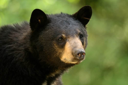

In [ ]:
# To view downloaded images
Image.open("bears/black/00000125.jpg").to_thumb(128,128)

In [ ]:
# To check for corrupt files
failed = verify_images(images)
failed

(#0) []

In [ ]:
# Remove the failed images
failed.map(Path.unlink);
# If you run images again, it shows the number after removing the failed images

## From Data to DataLoaders

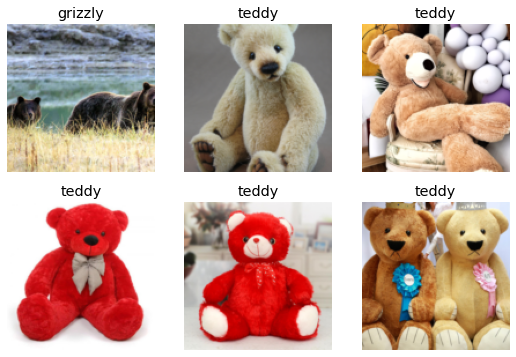

In [ ]:
# Datablock is a template for creating dataloaders
bears = DataBlock(
    # Tuple specifiying types for the independent and dependent variable (x, y)
    blocks=(ImageBlock, CategoryBlock), 
    # function takes a path and return a list of all images in the path
    get_items=get_image_files, 
    #splitting into training and validation set
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    # parent_label gets the name of the folder the file is in = type of bear
    get_y=parent_label,
    # images are grouped in a big array/ tensor (64 by default) and fed to the model in mini-batches  
    # Approach 1: Transform the images to the same size
    # Problem: May result in loss of important details
    item_tfms=Resize(128))

# We need to tell fastai the actual source of our data (path of the images)
dls = bears.dataloaders(path)

# Show items in the dataloader
dls.valid.show_batch(max_n=6, nrows=2)

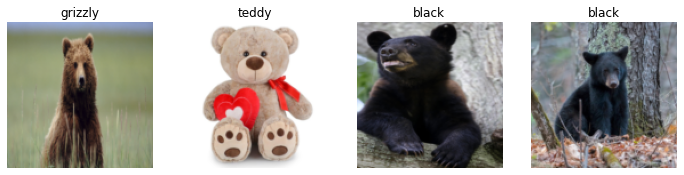

In [ ]:
# Approach 2: squish/ stretch
# Problem: lead to unrealistic shapes and model with lower accuracy
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

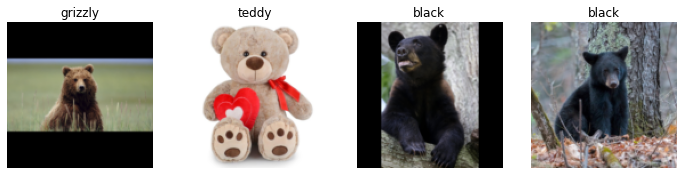

In [ ]:
# approach 3: pad images with zeros (black)
# Problem: wasted computation and lower effective resolution for the images
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

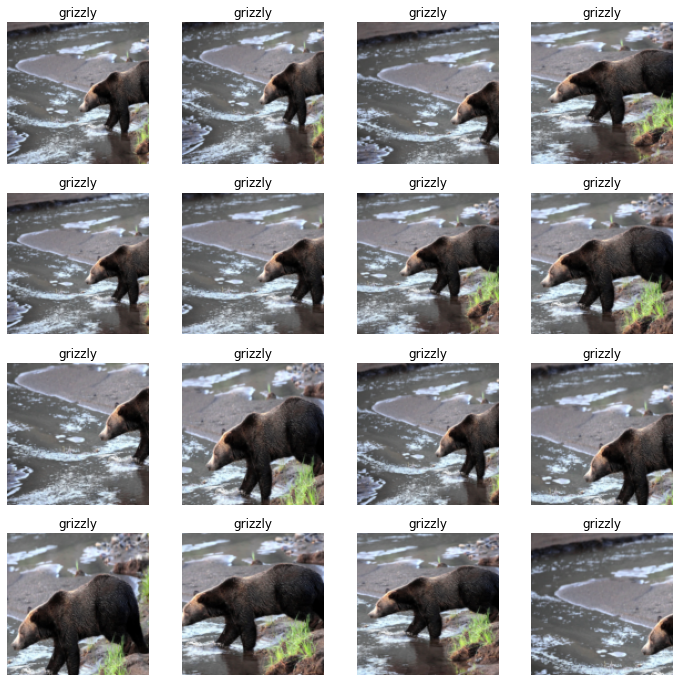

In [ ]:
# Approach 4: Randomly select a part of the image to focus on on each epoch
# Benefit: reflects real world images (framed differently) and model will recognise different features
# min scale determines how much of the image to select at minimum each time
# This is a form of data augmentation
# unique = True gives us the same image repeated with different transforms
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=16, nrows=4, unique=True)

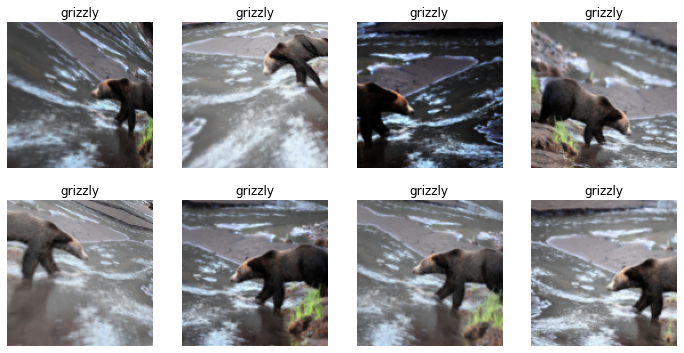

In [ ]:
# Approach 5: augmentation including rotation, flipping, perspective warping, brightness changes, contrast changes
# using double the amount of augmentations
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

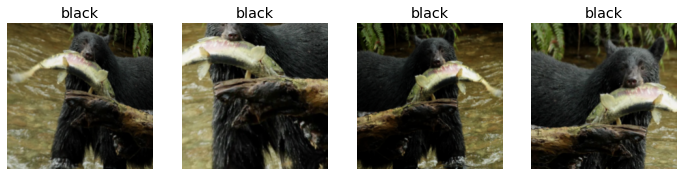

In [ ]:
# data transformation and augmentation (see above for diff approaches)
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
# training the data
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.383058,0.103781,0.011905,00:27


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.177085,0.039202,0.011905,00:27
1,0.152004,0.004944,0.000000,00:28
2,0.127110,0.003728,0.000000,00:27
3,0.106272,0.004351,0.000000,00:27


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


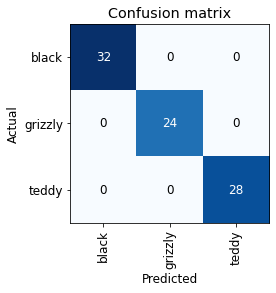

In [ ]:
# confusion matrix to visualise results
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

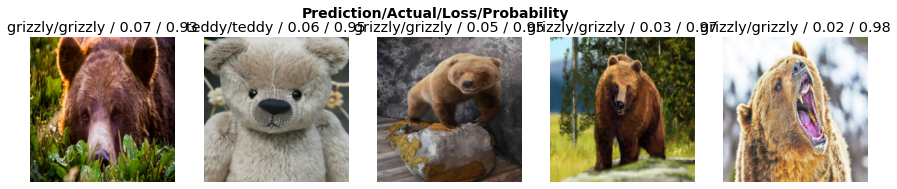

In [ ]:
# Sort images by their losses and present images with highest loss
# Loss is higher if model is incorrect or correct but not confident
# Each image labelled with prediction, actual label, loss, probability (confidence) 
interp.plot_top_losses(5, nrows=1)

In [ ]:
# Technically supposed to clean data before training
# But training a quick and simple model first can help with data cleaning
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

**TO TEST WHETHER THE EXPORTED FILE IS SAVED IN GOOGLE DRIVE BY RUNNING THIS FIRST NEXT TIME**

In [ ]:
# Will save both the architecture and the parameters (including dataloaders definition)
learn.export()

In [ ]:
# To check that file exists 
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# To download file
from google.colab import files
files.download(Path('export.pkl'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
# To load the exported parameters into a different model for predictions (inference)
from google.colab import drive
drive.mount('/content/drive')
learn_inf = load_learner('/content/drive/My Drive/Fast.ai Course/Models/bear_classifier.pkl')

Mounted at /content/drive


In [ ]:
# passing a file name to get prediction for 1 image
# Will get predicted categoy , index of predicted category, and probabilities of each category
learn_inf.predict('bears/grizzly/00000062.jpg')

In [4]:
# Acess dataloaders as attribute of Learner
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Creating a Notebook App from the Model

In [5]:
# Define the variables
button_upload = widgets.FileUpload()
display_pic = widgets.Output()
label_prediction = widgets.Label()

In [6]:
def on_click_classify(change):
    image = PILImage.create(button_upload.data[-1])
    display_pic.clear_output()
    with display_pic: 
      display(image.to_thumb(128,128))
    prediction,prediction_idex,probability = learn_inf.predict(image)
    label_prediction.value = f'Prediction: {prediction}; Probability: {probability[prediction_idex]:.04f}'

button_run = widgets.Button(description='Classify')
button_run.on_click(on_click_classify)

In [7]:
VBox([widgets.Label('Select your bear!'), 
      button_upload, button_run, display_pic, label_prediction])

### Turning Your Notebook into a Real App

In [1]:
# Voila
!pip install voila
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: C:\Users\Naomi\miniconda3\envs\py3\etc\jupyter
    - Validating...
      voila 0.3.5 ok
